In [1]:
import pandas as pd
import numpy as np
import pickle
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report
from matplotlib import pyplot as plt

In [2]:
pd.set_option("display.max_columns", None)

# 데이터

In [3]:
with open(f"./datasets/X_samples.pickle", "rb") as f:
    X_samples = pickle.load(f)
    
with open(f"./datasets/y_samples.pickle", "rb") as f:
    y_samples = pickle.load(f)
    
with open(f"./datasets/X_test.pickle", "rb") as f:
    X_test = pickle.load(f)
    
with open(f"./datasets/y_test.pickle", "rb") as f:
    y_test = pickle.load(f)

In [4]:
X_test.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
201810,0.579847,-0.011862,1.035499,-0.317540,0.216728,1.201270,-0.537323,1.319719,-0.189181,-0.627079,-0.131042,0.186976,0.428736,-0.650821,0.607427,-1.605008,-0.426110,-0.604022,0.099792,0.000011,-0.286629,0.166828,0.550873,-0.323683,-0.402491,0.195611,-0.573086,-0.079200,0.015847,-0.254035
264506,0.901937,2.267601,-1.634754,-2.368609,-2.592182,1.161092,3.434814,-1.615728,0.797080,-1.404452,1.591339,-0.219360,-0.722225,0.316331,-0.203926,0.188359,-0.707386,0.435844,-0.286008,-0.261407,-0.343678,-0.163936,-0.078568,0.259323,0.687408,-0.131926,-0.141368,0.026772,-0.055990,0.041920
63736,-0.397573,1.118301,-1.260762,0.981093,-0.380698,-1.876228,-0.490142,-1.089500,0.062601,0.119233,0.495179,-0.818852,-1.269072,-1.259742,-0.383677,0.541024,1.271092,0.402624,-0.814504,0.430227,0.227343,0.364685,0.773901,-0.193256,0.415118,0.360261,-0.054869,0.016690,0.043857,1.553832
241327,0.778757,2.063018,0.608260,-3.168853,0.618313,1.228515,-1.367266,0.683151,-0.308130,-0.147176,-0.859443,1.672501,0.060919,-0.917332,-2.099999,-0.637629,0.540038,1.976581,1.105321,-0.025014,-0.155587,-0.022321,0.076885,-0.042470,0.578092,0.345450,0.660782,-0.089294,-0.023863,-0.296793
271841,0.940836,-1.212528,0.730185,1.549615,-0.954037,0.008643,-0.092019,0.124386,0.595537,-0.570630,-1.090583,0.339272,0.843626,0.394601,0.266667,-0.512564,0.792514,-0.751414,0.277571,0.372448,-0.012042,-0.161695,-0.744489,-0.173554,-0.405409,0.217600,0.357895,-0.143519,-0.050795,0.034654


In [5]:
y_test.head()

201810    0
264506    0
63736     0
241327    0
271841    0
Name: Class, dtype: int64

In [6]:
for key, sample in X_samples.items():
    y = y_samples[key]
    total = len(y)
    counts = y.value_counts()
    
    print('=' * 100)
    print(key)
    print('=' * 100)
    print(sample.head())
    print('-' * 100)
    print(counts)
    print('-' * 30)
    print(f"Total : {total}")
    for idx in counts.index:
        print(f"{idx} 비율 : {counts[idx] / total * 100:6.2f} %")
    print('=' * 100)

Raw
            Time        V1        V2        V3        V4        V5        V6  \
143144  0.005428 -0.540939  0.637584  2.439590  1.316115  0.742650  1.671102   
258914  0.871545  1.923123 -1.555096  0.211476 -0.174906 -1.760650  0.456333   
51111  -0.468709 -1.939810 -1.039497  0.429346 -0.198014  2.693946 -2.792994   
146949  0.038652 -0.801246  1.067120  0.506310 -2.533708  0.597024 -1.446026   
135606 -0.039556 -0.280807  1.109719  0.944761 -0.132693  0.423860 -0.509289   

              V7        V8        V9       V10       V11       V12       V13  \
143144  0.280149  0.293844  0.026988 -0.120361 -1.040090  1.148056  1.069975   
258914 -1.652432  0.375407  0.892833  0.788104 -0.439165  0.143663 -1.216406   
51111  -0.279832  0.114651 -0.089721 -1.381296  0.012582 -0.794746 -1.833108   
146949  1.376331 -0.269470  0.208041 -0.934162 -0.882872  0.294591  0.305609   
135606  0.698370 -0.020385 -0.333794 -0.510310 -0.965409 -0.370223  0.236423   

             V14       V15       V

# CatBoost

In [7]:
def show_data_info(y):
    total = len(y)
    counts = y.value_counts()
    print('=' * 80)
    print(counts)
    print('-' * 30)
    for idx in counts.index:
        print(f"{idx} 비율 : {counts[idx] / total * 100:6.2f} %")
    print('=' * 80)

def evaluate_model(clf, x_test, y_test):
    y_proba = clf.predict_proba(x_test)
    y_pred = clf.predict(x_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    fl = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_proba[:, 1])
    
    print('=' * 80)
    print('Confusion Matrix')
    print(confusion_matrix(y_test, y_pred))
    print('-' * 60)
    print(f'Accuracy  : {accuracy}')
    print(f'Precision : {precision}')
    print(f'Recall    : {recall}')
    print(f'F1-Score  : {fl}')
    print('-' * 60)
    print(classification_report(y_test,y_pred))
    print('-' * 60)
    print(f'ROC AUC : {roc_auc}')
    print('=' * 80)
    
    return accuracy, precision, recall, fl, roc_auc

In [8]:
clfs, results = {}, {}

for key, X in X_samples.items():
    y = y_samples[key]
    
    print('=' * 80)
    print(key)
    show_data_info(y)
    
    clf = CatBoostClassifier(eval_metric='F1', early_stopping_rounds=100, verbose=False)
    clf.fit(X, y, eval_set=(X_test, y_test))
    
    print(f'CatBoost {key}')
    result = evaluate_model(clf, X_test, y_test)
    
    clfs[key] = clf
    results[key] = result

Raw
0    227447
1       398
Name: Class, dtype: int64
------------------------------
0 비율 :  99.83 %
1 비율 :   0.17 %
CatBoost Raw
Confusion Matrix
[[56865     3]
 [   24    70]]
------------------------------------------------------------
Accuracy  : 0.9995259997893332
Precision : 0.958904109589041
Recall    : 0.7446808510638298
F1-Score  : 0.8383233532934131
------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56868
           1       0.96      0.74      0.84        94

    accuracy                           1.00     56962
   macro avg       0.98      0.87      0.92     56962
weighted avg       1.00      1.00      1.00     56962

------------------------------------------------------------
ROC AUC : 0.9757617117056447
SMOTE
0    227447
1    227447
Name: Class, dtype: int64
------------------------------
0 비율 :  50.00 %
1 비율 :  50.00 %
CatBoost SMOTE
Confusion Matrix
[[56790  

In [9]:
class_weights = ['Balanced', 'SqrtBalanced']

for class_weight in class_weights:
    X, y = X_samples['Raw'], y_samples['Raw']
    
    print('=' * 80)
    print('Raw')
    show_data_info(y)
    
    clf = CatBoostClassifier(eval_metric='F1', auto_class_weights=class_weight,
                             early_stopping_rounds=100, verbose=False)
    clf.fit(X, y, eval_set=(X_test, y_test))
    
    print(f'CatBoost {class_weight}')
    result = evaluate_model(clf, X_test, y_test)
    
    clfs[class_weight] = clf
    results[class_weight] = result

Raw
0    227447
1       398
Name: Class, dtype: int64
------------------------------
0 비율 :  99.83 %
1 비율 :   0.17 %
CatBoost Balanced
Confusion Matrix
[[54869  1999]
 [   10    84]]
------------------------------------------------------------
Accuracy  : 0.9647308732137214
Precision : 0.040326452232357174
Recall    : 0.8936170212765957
F1-Score  : 0.07717041800643086
------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.96      0.98     56868
           1       0.04      0.89      0.08        94

    accuracy                           0.96     56962
   macro avg       0.52      0.93      0.53     56962
weighted avg       1.00      0.96      0.98     56962

------------------------------------------------------------
ROC AUC : 0.9736473528095672
Raw
0    227447
1       398
Name: Class, dtype: int64
------------------------------
0 비율 :  99.83 %
1 비율 :   0.17 %
CatBoost SqrtBalanced
Confusion Ma

In [10]:
cols = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC_AUC']
    
evaluation = pd.DataFrame(results, index=cols)
evaluation

,Raw,SMOTE,ADASYN,CNN,SMOTE + ENN,ADASYN + ENN,Balanced,SqrtBalanced
Accuracy,0.999526,0.998332,0.998350,0.999544,0.998631,0.998297,0.964731,0.999508
Precision,0.958904,0.496774,0.500000,0.904762,0.557143,0.490683,0.040326,0.875000
Recall,0.744681,0.819149,0.819149,0.808511,0.829787,0.840426,0.893617,0.819149
F1-Score,0.838323,0.618474,0.620968,0.853933,0.666667,0.619608,0.077170,0.846154
ROC_AUC,0.975762,0.976030,0.975875,0.975923,0.979448,0.978338,0.973647,0.983558


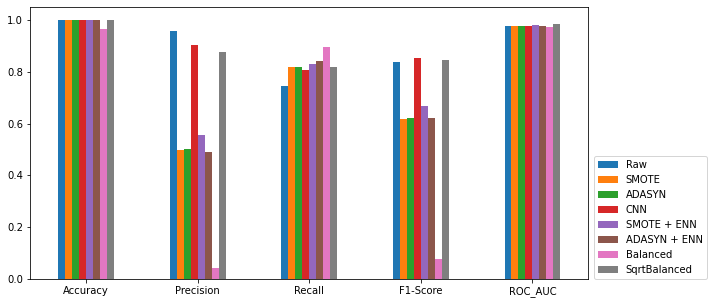

In [11]:
evaluation.plot(kind="bar", figsize=(10, 5), rot=0)
plt.legend(loc=(1.01, 0.))
plt.show()

## 가중치 부여

In [12]:
counts = y_samples['Raw'].value_counts()
counts

0    227447
1       398
Name: Class, dtype: int64

In [13]:
print(counts[0] / counts[1])
print(np.sqrt(counts[0] / counts[1]))

571.4748743718593
23.90554066261333


In [14]:
weights = np.linspace(1.0, 50.0, 30, endpoint=False)
weights

array([ 1.        ,  2.63333333,  4.26666667,  5.9       ,  7.53333333,
        9.16666667, 10.8       , 12.43333333, 14.06666667, 15.7       ,
       17.33333333, 18.96666667, 20.6       , 22.23333333, 23.86666667,
       25.5       , 27.13333333, 28.76666667, 30.4       , 32.03333333,
       33.66666667, 35.3       , 36.93333333, 38.56666667, 40.2       ,
       41.83333333, 43.46666667, 45.1       , 46.73333333, 48.36666667])

In [15]:
results_weight = {}

for weight in weights:
    X, y = X_samples['Raw'], y_samples['Raw']
    
    print('=' * 80)
    
    clf = CatBoostClassifier(eval_metric='F1', scale_pos_weight=weight,
                             early_stopping_rounds=100, verbose=False)
    clf.fit(X, y, eval_set=(X_test, y_test))
    
    print(f'Weight {weight}')
    result = evaluate_model(clf, X_test, y_test)
    
    results_weight[weight] = result

Weight 1.0
Confusion Matrix
[[56865     3]
 [   24    70]]
------------------------------------------------------------
Accuracy  : 0.9995259997893332
Precision : 0.958904109589041
Recall    : 0.7446808510638298
F1-Score  : 0.8383233532934131
------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56868
           1       0.96      0.74      0.84        94

    accuracy                           1.00     56962
   macro avg       0.98      0.87      0.92     56962
weighted avg       1.00      1.00      1.00     56962

------------------------------------------------------------
ROC AUC : 0.9757617117056447
Weight 2.6333333333333333
Confusion Matrix
[[56864     4]
 [   21    73]]
------------------------------------------------------------
Accuracy  : 0.9995611109160493
Precision : 0.948051948051948
Recall    : 0.776595744680851
F1-Score  : 0.8538011695906432
----------------------

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56868
           1       0.93      0.80      0.86        94

    accuracy                           1.00     56962
   macro avg       0.96      0.90      0.93     56962
weighted avg       1.00      1.00      1.00     56962

------------------------------------------------------------
ROC AUC : 0.9761392190051168
Weight 15.7
Confusion Matrix
[[56863     5]
 [   17    77]]
------------------------------------------------------------
Accuracy  : 0.9996137776061234
Precision : 0.9390243902439024
Recall    : 0.8191489361702128
F1-Score  : 0.875
------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56868
           1       0.94      0.82      0.88        94

    accuracy                           1.00     56962
   macro avg       0.97      0.91      0.94     56962
weighted avg      

Weight 28.766666666666666
Confusion Matrix
[[56846    22]
 [   18    76]]
------------------------------------------------------------
Accuracy  : 0.9992977774656788
Precision : 0.7755102040816326
Recall    : 0.8085106382978723
F1-Score  : 0.7916666666666665
------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56868
           1       0.78      0.81      0.79        94

    accuracy                           1.00     56962
   macro avg       0.89      0.90      0.90     56962
weighted avg       1.00      1.00      1.00     56962

------------------------------------------------------------
ROC AUC : 0.9791398221188599
Weight 30.4
Confusion Matrix
[[56854    14]
 [   16    78]]
------------------------------------------------------------
Accuracy  : 0.9994733330992591
Precision : 0.8478260869565217
Recall    : 0.8297872340425532
F1-Score  : 0.8387096774193549
------------------

Weight 43.46666666666667
Confusion Matrix
[[56861     7]
 [   18    76]]
------------------------------------------------------------
Accuracy  : 0.9995611109160493
Precision : 0.9156626506024096
Recall    : 0.8085106382978723
F1-Score  : 0.8587570621468926
------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56868
           1       0.92      0.81      0.86        94

    accuracy                           1.00     56962
   macro avg       0.96      0.90      0.93     56962
weighted avg       1.00      1.00      1.00     56962

------------------------------------------------------------
ROC AUC : 0.9723746219314904
Weight 45.1
Confusion Matrix
[[56859     9]
 [   18    76]]
------------------------------------------------------------
Accuracy  : 0.9995259997893332
Precision : 0.8941176470588236
Recall    : 0.8085106382978723
F1-Score  : 0.8491620111731844
-------------------

In [16]:
evaluation_weigth = pd.DataFrame(results_weight, index=cols)
evaluation_weigth

,1.000000,2.633333,4.266667,5.900000,7.533333,9.166667,10.800000,12.433333,14.066667,15.700000,17.333333,18.966667,20.600000,22.233333,23.866667,25.500000,27.133333,28.766667,30.400000,32.033333,33.666667,35.300000,36.933333,38.566667,40.200000,41.833333,43.466667,45.100000,46.733333,48.366667
Accuracy,0.999526,0.999561,0.999579,0.999491,0.999579,0.999438,0.999456,0.999579,0.999561,0.999614,0.999561,0.999561,0.999579,0.999368,0.999508,0.999438,0.999421,0.999298,0.999473,0.999438,0.999596,0.999508,0.999350,0.999298,0.999315,0.999579,0.999561,0.999526,0.999298,0.999315
Precision,0.958904,0.948052,0.948718,0.882353,0.926829,0.852273,0.846154,0.926829,0.925926,0.939024,0.905882,0.905882,0.926829,0.808511,0.875000,0.836957,0.842697,0.775510,0.847826,0.836957,0.938272,0.883721,0.800000,0.770000,0.777778,0.926829,0.915663,0.894118,0.764706,0.777778
Recall,0.744681,0.776596,0.787234,0.797872,0.808511,0.797872,0.819149,0.808511,0.797872,0.819149,0.819149,0.819149,0.808511,0.808511,0.819149,0.819149,0.797872,0.808511,0.829787,0.819149,0.808511,0.808511,0.808511,0.819149,0.819149,0.808511,0.808511,0.808511,0.829787,0.819149
F1-Score,0.838323,0.853801,0.860465,0.837989,0.863636,0.824176,0.832432,0.863636,0.857143,0.875000,0.860335,0.860335,0.863636,0.808511,0.846154,0.827957,0.819672,0.791667,0.838710,0.827957,0.868571,0.844444,0.804233,0.793814,0.797927,0.863636,0.858757,0.849162,0.795918,0.797927
ROC_AUC,0.975762,0.982550,0.982295,0.980819,0.980161,0.982035,0.981581,0.982874,0.976139,0.976336,0.978850,0.982304,0.983925,0.982381,0.983564,0.971817,0.982663,0.979140,0.977385,0.965092,0.980089,0.984711,0.972124,0.975221,0.961894,0.978681,0.972375,0.969242,0.968374,0.975955


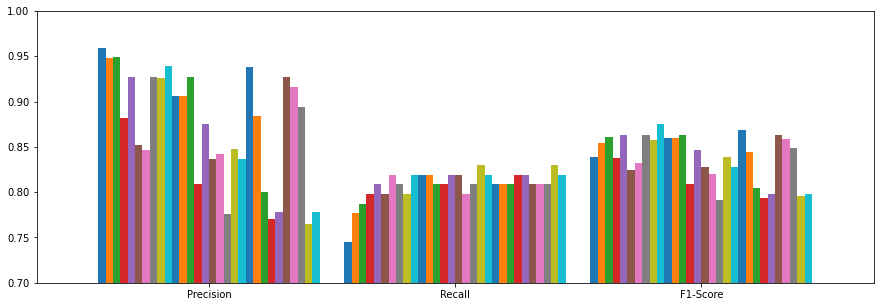

In [17]:
data = evaluation_weigth.loc[['Precision', 'Recall', 'F1-Score']]
data.plot(kind="bar", figsize=(15, 5), width=0.9, rot=0, legend=False)
plt.ylim(0.7, 1.0)
plt.show()